<h1 align="center">Lab #4: Graph Neural Networks</h1> 
<br />
<br />
<br />
<img src="../../images/network.png" style="display:block;margin-left:auto;margin-right:auto;width:80%;"></img>

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

import torch

%matplotlib inline

# Style pour le Notebook
from IPython.core.display import HTML

def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
# torch geometric
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    if torch.cuda.is_available():
        print(f'cuda version: {torch.version.cuda}')
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cpu' # or cu116 cu113

    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+${CUDA}.html
    import torch_geometric

try: 
    import torchmetrics
except ModuleNotFoundError:
    !pip install torchmetrics
    import torchmetrics

NameError: name 'torch' is not defined

In [4]:
import networkx as nx
from packaging import version
import sys 
import sknetwork as skn
import sklearn
import torch
import torch_geometric

print("Python version:", sys.version)
print("networkx version:", nx.__version__)
print("sklearn version:", sklearn.__version__)
print("torch version:", torch.__version__)
print("torch_geometric version:", torch_geometric.__version__)


# assert networkx version is greater or equal to 2.6
assert version.parse(nx.__version__) >= version.parse("2.6")

# assert torch version is greater or equal to '1.10.0'
assert version.parse(torch.__version__) >= version.parse("1.10.0")

# assert torch_geometric version is greater or equal to '2.1.0'
assert version.parse(torch_geometric.__version__) >= version.parse("2.1.0")

# assert scikit-learn version is greater to '1.1.3'
assert version.parse(sklearn.__version__) >= version.parse("1.1.3")

# assert python version is greater that 3.7
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 9  

# If working in colab mount the drive filesystem 
if 'google.colab' in str(get_ipython()):
    print('Working in colab')
    
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("working locally")

ModuleNotFoundError: No module named 'networkx'

# 0 - Tools

### Lauch Tensorboard

more information about [tensorboard](https://www.tensorflow.org/tensorboard)

```shell
> tensorboard --logdir=runs
```

### Lauch MLFlow 

more information about [MLFlow](https://mlflow.org/)

```shell
> mlflow ui
```

# 1 - Classification with Graph Convolutional Network Layer (GCN)

The GCN layer is mathematically defined as:

$$ \mathbf{h}^{(l+1)}_i = \sigma \left( \sum_{j \in \mathcal{N}_i \cup \{ i \} } \frac{1}{\sqrt{deg(i)} \cdot \sqrt{deg(j)}} \left( \mathbf{W} \cdot \mathbf{h}^{(l)}_j \right) + \mathbf{b} \right)$$

where neighboring node features are first transformed by a weight matrix , normalized by their degree, and finally summed up. Lastly, we apply the bias vector  to the aggregated output. This formula can be divided into the following steps:

1. Add self-loops to the adjacency matrix.
2. Linearly transform node feature matrix.
3. Compute normalization coefficients.
4. Normalize node features in .
5. Sum up neighboring node features ("add" aggregation).
6. Apply a final bias vector.

Steps 1-3 are typically computed before message passing takes place. Steps 4-5 can be easily processed using the **MessagePassing** base class. The full layer implementation is shown below:



In [5]:
import torch
import torch.nn as nn
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import numpy as np

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        h = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, h.size(0), dtype=h.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=h, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

**GCNConv** inherits from **MessagePassing** with "add" propagation. All the logic of the layer takes place in its **forward()** method. Here, we first add self-loops to our edge indices using the **torch_geometric.utils.add_self_loops()** function (step 1), as well as linearly transform node features by calling the **torch.nn.Linear** instance (step 2).

The normalization coefficients are derived by the node degrees $deg(i)$ for each node $i$ which gets transformed to $1/\left( \sqrt{deg(i)} \sqrt{deg(j)}\right)$ for each edge $(j, i) \in \mathcal{E}$. The result is saved in the tensor **norm** of shape **[num_edge, ]** (step 3).

We then call **propagate()**, which internally calls **message()**, **aggregate()** and **update()**. We pass the node embeddings $\mathbf{h}$ and the normalization coefficients **norm** as additional arguments for message propagation.

In the **message()** function, we need to normalize the neighboring node features **x_j** by **norm**. Here, **x_j** denotes a lifted tensor, which contains the source node features of each edge, i.e., the neighbors of each node. Node features can be automatically lifted by appending **_i** or **_j** to the variable name. In fact, any tensor can be converted this way, as long as they hold source or destination node features.

That is all that it takes to create a simple message passing layer. You can use this layer as a building block for deep architectures. Initializing and calling it is straightforward.

In [6]:
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        
        self.dp_rate = dp_rate_linear
        self.conv1 = GCNConv(c_in, c_hidden)
        self.conv2 = GCNConv(c_hidden, c_hidden)
        self.lin = Linear(c_hidden, c_out)
        self.reset_parameters()
        
        
    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        
    def encoder(self, x, edge_index):
        # first GCN layer 
        x = self.conv1(x, edge_index)
        # activation function 
        x = F.relu(x)
        # second GCN layer 
        x = self.conv2(x, edge_index)
        # activation function
        return F.relu(x)
        
        
    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        # first GCN layer 
        x = self.conv1(x, edge_index)
        # activation function 
        x = F.relu(x)
        x = F.dropout(x, p=self.dp_rate, training=self.training)
        # second GCN layer 
        x = self.conv2(x, edge_index)
        # activation function
        x = F.relu(x)
        x = F.dropout(x, p=self.dp_rate, training=self.training)
        # Head 
        x = self.lin(x)
        # training – apply dropout if is True. Default: True
        return F.log_softmax(x, dim=-1)

# Cora dataset 

For more informatiuon about the Cora dataset please visit teh following link 
* [Cora dataset](https://graphsandnetworks.com/the-cora-dataset/)

In [7]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root="./data", name='Cora')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')          # False
print(f'Is undirected: {data.is_undirected()}')            # True
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of features: {dataset.num_features}')
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of classes: 7
Number of features: 1433


In [8]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [9]:
def train(optimizer, model, data, device="cpu", debug=False):
    data.to(device)
    # Set the model variable to train=True
    model.train()
    # Step 1: reset the gradient of the back propagation
    optimizer.zero_grad()
    # Step 2: Forward pass
    out = model(data.x, data.edge_index)
    # Step 3: compute the loss on the train_node (the negative log likelihood loss).  
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_val = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    # Step 4: execute one backpropagation 
    loss.backward()
    # Step 5: update the learning weight according to the learning rate
    optimizer.step()
    return float(loss), float(loss_val)
        
@torch.no_grad()
def test(model, data, device="cpu"):
    from torchmetrics.classification import MulticlassAccuracy
    data.to(device)
    model.eval()
    accuracy = MulticlassAccuracy(num_classes=7)
    pred = model(data.x, data.edge_index).argmax(dim=-1)
    return (
        accuracy(pred[data.train_mask], data.y[data.train_mask]),
        accuracy(pred[data.val_mask], data.y[data.val_mask]), 
        accuracy(pred[data.test_mask], data.y[data.test_mask])
    )

In [1]:
from torch.utils.tensorboard import SummaryWriter

def run_GCN_model(dataset, device="cpu", lr=0.001, n_epoch=100, emb_size=50, dp_rate_linear=0.5):
    data = dataset[0]
    data.to(device)

    # run name
    comment = f" GCN N_epoch = {n_epoch}, lr = {lr}, emb_size = {emb_size}, dropout = {dp_rate_linear}"
    
    # initialize the model 
    model = Net(dataset.num_features, emb_size, dataset.num_classes, dp_rate_linear=dp_rate_linear).to(device)
    
    # Initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Initialize Tensor board
    writer = SummaryWriter(comment=comment)
    print(f"### run : {comment} ###")
    
    # execute n_epoch 
    for epoch in range(n_epoch):
        loss, loss_val = train(optimizer, model, data, debug=True)
        acc_train, acc_val, acc_test = test(model, data)

        writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalar('Loss/validation', loss_val, epoch)
        writer.add_scalar('Accuracy/train', acc_train, epoch)
        writer.add_scalar('Accuracy/validation', acc_val, epoch)
        writer.add_scalar('Accuracy/test', acc_test, epoch)
        if epoch % 10 == 0: 
            print(f'epoch {epoch:04d}, ' + 
                  f'train loss: {loss:.4f}, ' + 
                  f'train accuracy: {acc_train:.4f}, ' + 
                  f'validation accuracy: {acc_val:.4f}, ' +
                  f'test accuracy: {acc_test:.4f}' 
                 )
            
    return model

ModuleNotFoundError: No module named 'torch'

In [ ]:
best_model = run_GCN_model(dataset)

## Plot nodes embeddings

In [15]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data = dataset[0]
y = data.y[data.test_mask]
x = data.x[data.test_mask]

embeddings = best_model.encoder(data.x, data.edge_index)
X = embeddings[data.test_mask].detach().numpy()

scaler = StandardScaler()
Xscale = scaler.fit_transform(X)

tnse_2 = TSNE(n_components=2, init='random', learning_rate='auto')
coord = tnse_2.fit_transform(Xscale)

Text(0.5, 1.0, 'node embeddings in 2d euclidian space')

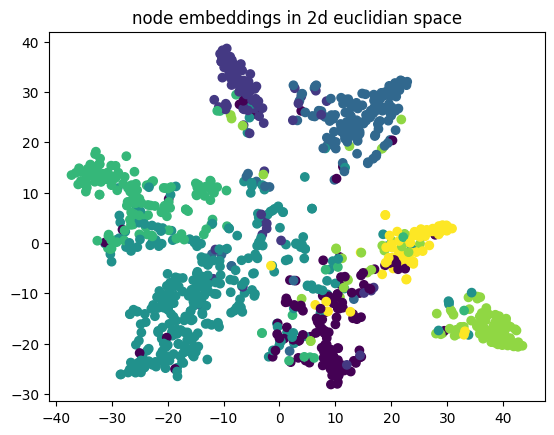

In [16]:
fig, ax = plt.subplots()
ax.scatter(coord[:,0], coord[:,1], c=y)
ax.set_title("node embeddings in 2d euclidian space")

# 2 - GraphSAGE

<img src="https://miro.medium.com/max/1100/0*BpHK8HwjeCtSw0Uh" alt="alt text" title="image Title" width="50%">

A first natural question is: Why shift from standard **GCN** to **GraphSAGE** ?

**As a result, GCNs are not very practical, limited in terms of memory when handling large networks, and even not suitable for some cases.**

**GraphSAGE** overcomes the previous challenges while relying on the same mathematical principles as GCNs. It provides a general inductive framework that is able to generate node embeddings for new nodes.

Introduced by the paper: _Inductive Representation Learning on Large Graphs_ [6] in 2017, **GraphSAGE, which stands for Graph SAmpling and AggreGatE**, has made a significant contribution to the GNN research area.

### So how does GraphSAGE work concretely?

Rather than training individual embeddings for each node, the model learns a function that generates embeddings by sampling and aggregating the features of the local neighborhood of a node.

$$\mathbf{h}^{(l+1)}_{\mathcal{N}(v)} = AGGREGATE \left( \{ \mathbf{h}_u^{(l)}, \forall u \in \mathcal{N}(v) \} \right) $$

$$ \mathbf{h}_u^{(l+1)} = \sigma \left( W \cdot CONCAT \left( \mathbf{h}_v^{(l)} ,  \mathbf{h}^{(l+1)}_{\mathcal{N}(v)} \right) \right)$$

At each iteration, the model follows two different steps:

1. Sample: Instead of using the entire neighborhood of a given node, the model uniformly samples a fixed-size set of neighbors.
2. Aggregate: Nodes aggregate information from their local neighbors as shown in the equation below. In the original paper [6], three aggregation functions are considered:

    - Mean aggregator: It consists in taking the average of the vectors of the neighboring nodes. Simple and efficient, this approach has led to good performances in the experiments carried out in the research paper. It is the one that has been retained in the application below.

     - LSTM aggregator: This aggregator has the potential to benefit from the greater expressive capabilities of the LTSMs architecture. To adapt it to graphs that have no natural order, the aggregator is applied to a random permutation of the node’s neighbors.
     
     - Pooling aggregator: It consists in feeding a fully connected neural network with the vector of each neighbor. After this transformation, a maximum pooling operation per element is applied to aggregate the information on all the neighbors. It has yielded very good results in the experiments with the paper.

### Subgraph Sampling 

One main advantage of **GrapheSage** is to be able to use subgraph samle during the learing phase and not the whole graph. We will use the pytorch_geometric **[NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader)** function to achive that.

**Question:** Plot the subgraph provided by the function **[NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader)** explain what you get.

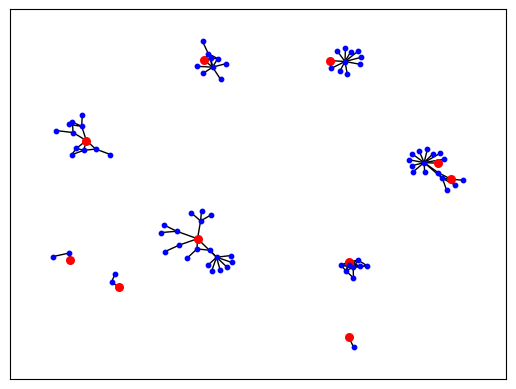

In [17]:
from torch_geometric.loader import NeighborLoader
import networkx as nx
import matplotlib.pylab as plt

# We sample the graph
# We sample 10 node from the origial graph with there subgraph (here the two hops neigborhood)  
# We limit the number of possible node:
#    - at 1 hop to be 10 
#    - at 2 hop to be 5 per node in the 1 hop neighborhood.
train_loader = NeighborLoader(data, input_nodes=data.train_mask, num_neighbors=[5, 10], shuffle=True, batch_size=10)

# we extract the edge list
batch = next(iter(train_loader))
e = batch.edge_index.numpy().T
#print(e)
# create the networkx graph
G = nx.from_edgelist(e)

### BEGIN SOLUTION 
fig, ax = plt.subplots(frameon=False)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, nodelist=list(range(batch.batch_size)), pos=pos, ax=ax, node_color="red", node_size=30)
nx.draw_networkx_nodes(G, nodelist=list(range(batch.batch_size, max(list(G.nodes()))+1 )), pos=pos, ax=ax, node_size=10, node_color="blue")
nx.draw_networkx_edges(G, ax=ax, pos=pos)
### END SOLUTION 

### GraphSAGE model

Read the following paper [1] and improve the SAGENet model bellow by designing the model according to the inputs you get in the paper in [1].

### Reference 
[1] [Design Space of Graph Neural Networks, J. You, R. Ying, J. Leskovec. NeurIPS (2020)](https://proceedings.neurips.cc/paper/2020/file/c5c3d4fe6b2cc463c7d7ecba17cc9de7-Paper.pdf).

In [18]:
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
import torch.nn.functional as F

class SAGENet(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out):
        
        super(SAGENet, self).__init__()
        self.GNN1 = SAGEConv(c_in, c_hidden, normalize=False)
        self.GNN2 = SAGEConv(c_hidden, c_hidden, normalize=False)
        self.lin = Linear(c_hidden, c_hidden)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.GNN1.reset_parameters()
        self.GNN2.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x, edge_index):
        # Layer 1
        x = self.GNN1(x, edge_index)
        h_1 = F.relu(x)
        
        # Layer 2
        h_1 = self.GNN2(h_1, edge_index)
        h_2 = F.relu(h_1)
        
        # Head 
        h_out = self.lin(h_2)
        # training – apply dropout if is True. Default: True
        return F.log_softmax(h_out, dim=-1)

In [19]:
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
import torch.nn.functional as F

class ImproveSAGENet(torch.nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, c_in, c_hidden, c_out, dropout=0.5, batchnorm=False, normalize=False, aggr="mean"):
        
        super(ImproveSAGENet, self).__init__()
        self.GNN1 = SAGEConv(c_in, c_hidden, normalize=normalize, aggr=aggr)
        self.GNN2 = SAGEConv(c_hidden, c_hidden, normalize=normalize, aggr=aggr)
        self.GNN3 = SAGEConv(c_hidden, c_hidden, normalize=normalize, aggr=aggr)
        self.BN1 = torch.nn.BatchNorm1d(c_hidden)
        self.BN2 = torch.nn.BatchNorm1d(c_hidden)
        self.BN3 = torch.nn.BatchNorm1d(c_hidden)
        self.lin = Linear(3*c_hidden, c_out)   
        self.dropout = dropout
        self.batchnorm = batchnorm
        self.prelu1 = torch.nn.PReLU()
        self.prelu2 = torch.nn.PReLU()
        self.prelu3 = torch.nn.PReLU()
        self.reset_parameters()
    
    def reset_parameters(self):
        self.GNN1.reset_parameters()
        self.GNN2.reset_parameters()
        self.GNN3.reset_parameters()
        self.BN1.reset_parameters()
        self.BN2.reset_parameters()
        self.lin.reset_parameters()
        
    def encoder(self, x, edge_index):
        
        # Layer 1
        x = self.GNN1(x, edge_index)
        if self.batchnorm:
            x = self.BN1(x)
        h_1 = self.prelu1(x)
        
        # Layer 2
        h_1 = self.GNN2(h_1, edge_index)
        if self.batchnorm:
            h_1 = self.BN2(h_1)
        h_2 = self.prelu2(h_1)
        
        # Layer 3
        h_2 = self.GNN3(h_2, edge_index)
        if self.batchnorm:
            h_2 = self.BN3(h_2)
        return self.prelu3(h_2)

    def forward(self, x, edge_index):
        # Layer 1
        x = self.GNN1(x, edge_index)
        if self.batchnorm:
            x = self.BN1(x)
        h_1 = self.prelu1(x)
        if self.dropout > 0.0:
            h_1 = F.dropout(h_1, p=self.dropout, training=self.training)
        
        
        # Layer 2
        h_1 = self.GNN2(h_1, edge_index)
        if self.batchnorm:
            h_1 = self.BN2(h_1)
        h_2 = self.prelu2(h_1)
        if self.dropout > 0.0:
            h_2 = F.dropout(h_2, p=self.dropout, training=self.training)
        
        
        # Layer 3
        h_2 = self.GNN3(h_2, edge_index)
        if self.batchnorm:
            h_2 = self.BN3(h_2)
        h_3 = self.prelu3(h_2)
        if self.dropout > 0.0:
            h_3 = F.dropout(h_3, p=self.dropout, training=self.training)
        
        
        # Post processsing
        h_out = torch.cat((h_1, h_2, h_3), -1)
        h_out = self.lin(h_out)
        return F.log_softmax(h_out, dim=-1)
    
    ### END SOLUTION

### Training/Test/Validation functions

In [20]:
def train(train_loader, optimizer, model, device):
    model.train()
    total_loss = total_examples = 0
    for batch in train_loader:
        batch.to(device)
        # Step 1: reset the gradient of the back propagation
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        # Step 2: Forward pass
        y_hat = model(batch.x, batch.edge_index)[:batch.batch_size]
        # Step 3: compute the loss on the train_node (the negative log likelihood loss).  
        loss = F.nll_loss(y_hat, y)
        total_loss += float(loss) * batch.batch_size
        total_examples += batch.batch_size
        # Step 4: execute one backpropagation 
        loss.backward()
        # Step 5: update the learning weight according to the learning rate
        optimizer.step()
    return total_loss / total_examples

@torch.no_grad()
def test(model, data, device="cpu"):
    from torchmetrics import Accuracy
    
    data.to(device)
    model.eval()
    accuracy = Accuracy(task="multiclass", num_classes=7)
    pred = model(data.x, data.edge_index).argmax(dim=-1)
    
    return (
        accuracy(pred[data.train_mask], data.y[data.train_mask]),
        accuracy(pred[data.val_mask], data.y[data.val_mask]), 
        accuracy(pred[data.test_mask], data.y[data.test_mask])
    )

@torch.no_grad()
def validation(model, data, device="cpu"):
    data.to(device)
    y = data.y
    y_hat = model(data.x, data.edge_index)
    return F.nll_loss(y_hat[data.val_mask], y[data.val_mask])

### Run the train and validate the model

In [21]:
from torch_geometric.loader import NeighborLoader
from torch.utils.tensorboard import SummaryWriter

def run_SAGE_model(dataset, 
                   batch_size=32, 
                   lr=0.001, 
                   n_epoch=200, 
                   emb_size=50, 
                   dropout=0.5, 
                   device="cpu",
                   normalize=False,
                   aggr="mean",
                   batchnorm=False): 
    
    data = dataset[0]
    print(dataset, dataset.num_features, dataset.num_classes)
    
    comment = f" GrahSAGE n_epoch = {n_epoch}, lr = {lr}, emb_size = {emb_size}, dropout = {dropout}, batchnorm = {batchnorm}, batch_size = {batch_size}, normalize={normalize}, aggr = {aggr}"
    
    # Initialized the network
    #model = SAGENet(dataset.num_features, emb_size, dataset.num_classes).to(device)
    model = ImproveSAGENet(dataset.num_features, emb_size, dataset.num_classes, dropout=dropout, batchnorm=batchnorm, normalize=normalize, aggr=aggr).to(device)
    
    # Initialized the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Sample the graph
    train_loader = NeighborLoader(data, input_nodes=data.train_mask, num_neighbors=[20, 50], shuffle=True, batch_size=batch_size)

    # Initialize Tensor board
    writer = SummaryWriter(comment=comment)
    print(f"### run : {comment} ###")
    # execute n_epoch
    best_acc_train, best_acc_val, best_acc_test, best_epoch = 0.0, 0.0, 0.0, 0
    for epoch in range(1, n_epoch):
        loss = train(train_loader, optimizer, model, device)
        loss_val = validation(model, data)
        acc_train, acc_val, acc_test = test(model, data)
        
        # Compute the best metric
        if acc_val > best_acc_val:
            best_acc_train = acc_train
            best_acc_val = acc_val
            best_acc_test = acc_test
            best_model = model
            best_epoch = epoch

        writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalar('Loss/validation', loss_val, epoch)
        writer.add_scalar('Accuracy/train', acc_train, epoch)
        writer.add_scalar('Accuracy/validation', acc_val, epoch)
        writer.add_scalar('Accuracy/test', acc_test, epoch)
        if epoch % 10 == 0:
            print(f'epoch {epoch:04d}, train loss: {loss:.2f} ' +
                  f'validation loss:{loss_val:.2f} ' + 
                  f'train accuracy: {acc_train:.2f}, ' + 
                  f'validation accuracy: {acc_val:.2f}, ' +
                  f'test accuracy: {acc_test:.2f}' )
            
    return best_acc_train, best_acc_val, best_acc_test, best_epoch, model

In [22]:
dataset

Cora()

### Run the model and store the information with MLFlow 

In [23]:
from mlflow import log_metric, log_param, log_artifacts
import mlflow 

# Hyperparameters
emb_size = 16 
n_epoch = 50
lr = 0.1
batchnorm = False
batch_size = 8

### BEGIN SOLUTION
emb_size = 32 
n_epoch = 100
lr = 0.001
batchnorm = False
batch_size = 8
dropout = 0.1
aggr="mean"
normalize=False
### END SOLUTION

# Set an experiment name, which must be unique and case-sensitive.
experiment = mlflow.set_experiment("GraphSage Classification")
data = dataset[0]
with mlflow.start_run():
    log_param("emb_size", emb_size)
    log_param("dropout", dropout)
    log_param("lr", lr)
    log_param("n_epoch", n_epoch)
    log_param("batchnorm", batchnorm)
    log_param("batch_size", batch_size)
    log_param("aggr", aggr)
    
    acc_train, acc_val, acc_test, epoch, best_model = run_SAGE_model(dataset, 
                                                                batch_size=batch_size, 
                                                                lr=lr, 
                                                                n_epoch=n_epoch, 
                                                                emb_size=emb_size, 
                                                                dropout=dropout,
                                                                aggr=aggr,
                                                                normalize=normalize,
                                                                batchnorm=batchnorm)
    log_metric("acc_train", acc_train)
    log_metric("acc_val", acc_val)
    log_metric("acc_test", acc_test)
    log_metric("best epoch", epoch)
    mlflow.pytorch.log_model(best_model, "model")

Cora() 1433 7
### run :  GrahSAGE n_epoch = 100, lr = 0.001, emb_size = 32, dropout = 0.1, batchnorm = False, batch_size = 8, normalize=False, aggr = mean ###
epoch 0010, train loss: 0.01 validation loss:0.80 train accuracy: 1.00, validation accuracy: 0.77, test accuracy: 0.79
epoch 0020, train loss: 0.00 validation loss:0.93 train accuracy: 1.00, validation accuracy: 0.77, test accuracy: 0.79
epoch 0030, train loss: 0.00 validation loss:0.97 train accuracy: 1.00, validation accuracy: 0.77, test accuracy: 0.79
epoch 0040, train loss: 0.00 validation loss:1.03 train accuracy: 1.00, validation accuracy: 0.77, test accuracy: 0.79
epoch 0050, train loss: 0.00 validation loss:1.04 train accuracy: 1.00, validation accuracy: 0.77, test accuracy: 0.79
epoch 0060, train loss: 0.00 validation loss:1.08 train accuracy: 1.00, validation accuracy: 0.76, test accuracy: 0.78
epoch 0070, train loss: 0.00 validation loss:1.20 train accuracy: 1.00, validation accuracy: 0.77, test accuracy: 0.79
epoch 00

### Plot the node embeddings 

In [54]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data = dataset[0]
y = data.y[data.test_mask]
x = data.x[data.test_mask]

embeddings = best_model.encoder(data.x, data.edge_index)
X = embeddings[data.test_mask].detach().numpy()

scaler = StandardScaler()
Xscale = scaler.fit_transform(X)

tnse_2 = TSNE(n_components=2, init='random', learning_rate='auto')
coord = tnse_2.fit_transform(Xscale)

Text(0.5, 1.0, 'node embeddings in 2d euclidian space')

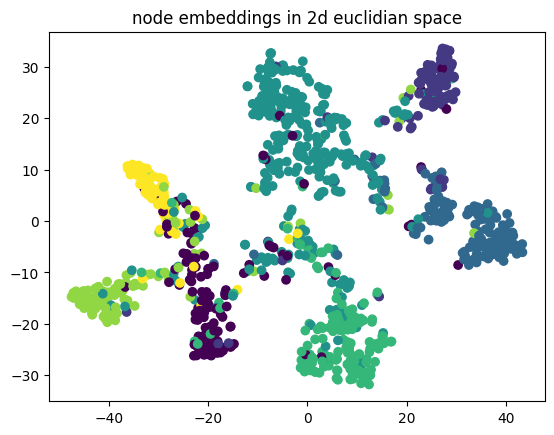

In [55]:
fig, ax = plt.subplots()
ax.scatter(coord[:,0], coord[:,1], c=y)
ax.set_title("node embeddings in 2d euclidian space")

# Use the [ogb](https://ogb.stanford.edu/) [arXiv dataset](https://ogb.stanford.edu/docs/nodeprop/) 

In order to be more relaistic we should use a larger dataset

In [44]:
from ogb.nodeproppred import NodePropPredDataset
from torch_geometric.data import DataLoader
import numpy as np


# Download and process data at './dataset/ogbg_molhiv/'
dataset_large = NodePropPredDataset(name = "ogbn-arxiv", root='data/')

split_idx = dataset_large.get_idx_split()
 
split_idx = dataset_large.get_idx_split() 
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph, label = dataset_large[0]
edge_index = graph["edge_index"]
X = graph["node_feat"]
print('num nodes =', graph['num_nodes'],", number of train nodes = ", train_idx.shape[0], ", node feature size =", X.shape[1], ", number of class =", np.unique(label).shape[0])

Downloaded 0.08 GB: 100%|█████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.55it/s]


Extracting data/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Saving...


num nodes = 169343 , number of train nodes =  90941 , node feature size = 128 , number of class = 40


# 3 - Edge-level tasks: Link prediction

In some applications, we might have to predict on an edge-level instead of node-level.
The most common edge-level task in GNN is link prediction.
Link prediction means that given a graph, we want to predict whether there will be/should be an edge between two nodes or not.
For example, in a social network, this is used by Facebook and co to propose new friends to you.
Again, graph level information can be crucial to perform this task.
The output prediction is usually done by performing a similarity metric on the pair of node features,
which should be 1 if there should be a link, and otherwise close to 0.
To keep the tutorial short, we will not implement this task ourselves.

### decoder or link predictor 

for two node $n_1, n_2$ with their respective embedding $h_1, h_2$ if their $ \sigma (h_1^T \cdot h_2) > 0.5$ (where $\sigma$ is the sigmoid function) we predict that they should be a link between them.

### Training
For trainning we are using positive and negative sample in order to train our model. In order to learn useful, predictive representations in a fully unsupervised setting, we apply graph-based loss function to the output representations, $z_u, \forall u \in V$. Thegraph-based loss function encourages nearby nodes to have similar representations, while enforcing
that the representations of disparate nodes are highly distinct

$$ J_G(\mathbf{z}_u) = - \log( \sigma(\mathbf{z}_u^T \mathbf{z}_v) ) - Q \cdot \mathbb{E}_{v_n \sim P_n(v)} \log(-\mathbf{z}_u^T \mathbf{z}_n) $$


where $v$ is a node that co-occurs near $u$, $\sigma$ is the sigmoid function, $P_n$ is a negative sampling distribution, and $Q$ defines the number of negative sample.

### TODO 

Implement the misssing encoder function, the encoder is just the node embedding of the GNN.

### Question 

* What is a good Fraction of negative sample to use during the training ?

In [56]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

class SAGELinkPreditor(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5):
        
        super(SAGELinkPreditor, self).__init__()

        self.sage1 = SAGEConv(c_in, c_hidden, normalize=False)
        self.batchnorm = torch.nn.BatchNorm1d(c_hidden)
        self.sage2 = SAGEConv(c_hidden, c_hidden, normalize=False)
        self.dropout = dp_rate_linear

    def reset_parameters(self):
        self.sage1.reset_parameters()
        self.sage2.reset_parameters()

    def encode(self, x, edge_index):
        ### BEGIN SOLUTION
        x = self.sage1(x, edge_index)
        x = self.batchnorm(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        return x
        ### END SOLUTION
    
    def decode(self, z, edge_label_index):
        # cosine similarity
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim = -1)

In [57]:
from tqdm import tqdm
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import NeighborLoader

def train(train_loader, model, optimizer, criterion, device="cpu", frac_neg=1):
    """
    Single epoch model training in batches.
    :return: total loss for the epoch
    """
    model.train()
    total_examples = total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch.batch_size
        
        # generate embeddings
        z = model.encode(batch.x, batch.edge_index)
        
        # generate fake edges 
        neg_edge_index = negative_sampling(edge_index = batch.edge_index, 
                                           num_nodes = batch.num_nodes, 
                                           num_neg_samples = int(frac_neg*batch.edge_index.size(1)), 
                                           method = 'sparse')

        # concatenate the real and the fake edges
        edge_label_index = torch.cat([batch.edge_index, neg_edge_index], dim = -1)
        
        # create the grounth true label
        edge_label = torch.cat([torch.ones(batch.edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim = 0)

        # compute the cosine similarity between two node embeddings 
        out = model.decode(z, edge_label_index).view(-1)
        
        # compute the loss
        loss = criterion(out, edge_label)

        # standard torch mechanics here
        # backpropagation 
        loss.backward()
        # gradient descent step
        optimizer.step()
        
        total_examples += batch_size
        total_loss += float(loss) * batch_size
    return total_loss / total_examples

In [58]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import numpy as np

@torch.no_grad()
def test(loader, model, device="cpu"):
    """
        Evalutes the model on the test set.
    :param loader: the batch loader
    :return: a score
    """
    model.eval()
    scores = []
    mean_auc = []
    mean_acc = []
    threshold = torch.tensor([0.7])
    for batch in loader:
        batch.to(device)
        # Positive sample
        z = model.encode(batch.x, batch.edge_index)
       
        
        # negative sample
        neg_edge_index = negative_sampling(edge_index = batch.edge_index, 
                                           num_nodes = batch.num_nodes, 
                                           num_neg_samples = None, 
                                           method = 'sparse')
        
        
        # concatenate the real and the fake edges
        edge_label_index = torch.cat([batch.edge_index, neg_edge_index], dim = -1)
        
        # create the grounth true label
        edge_label = torch.cat([torch.ones(batch.edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim = 0)
        
        
        out = model.decode(z, edge_label_index).view(-1).sigmoid()
        pred = (out > threshold).float() * 1
        
        # score
        score = f1_score(edge_label, pred.cpu().numpy())
        auc = roc_auc_score(edge_label, pred.cpu().numpy(), average=None)
        acc = accuracy_score(edge_label, pred.cpu().numpy())
        
        mean_auc.append(auc)
        scores.append(score)
        mean_acc.append(acc)
    return np.average(scores), np.average(mean_auc), np.average(acc)

In [59]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from datetime import datetime

def run_link_prediction(data, emb_size = 50, dropout = 0.5, n_epoch = 100, lr = 0.001, frac_neg=1):
    # run name
    run_id = int(datetime.timestamp(datetime.now()))
    comment = f" Link prediction run_id={run_id} n_epoch = {n_epoch}, lr = {lr}, emb_size = {emb_size}, dropout = {dropout}"

    # Tensor board 
    writer = SummaryWriter(comment=comment)
    
    # Sample the graph
    train_loader = NeighborLoader(data, input_nodes=data.train_mask, num_neighbors=[20, 30], shuffle=True, batch_size=10)
    test_loader = NeighborLoader(data, input_nodes=data.test_mask, num_neighbors=[20, 30], shuffle=True, batch_size=10)
    val_loader = NeighborLoader(data, input_nodes=data.val_mask, num_neighbors=[20, 30], shuffle=True, batch_size=10)

    # Initialize the model
    model = SAGELinkPreditor(dataset.num_features, emb_size, emb_size, dropout)

    # Optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)

    # BCELoss creates a criterion that measures the Binary Cross Entropy between the target and the output.
    criterion = torch.nn.BCEWithLogitsLoss()
    print(f"*** start the training: {comment} ***")
    best_test_f1, best_val_f1, test_auc, best_test_acc, best_model = 0.0, 0.0,0.0, 0.0, ""
    for epoch in range(n_epoch):
        loss = train(train_loader, model, optimizer, criterion, frac_neg=frac_neg)
        val_f1, val_auc, val_acc = test(val_loader, model)
        test_f1, test_auc, test_acc = test(test_loader, model)
        # compute the best metric
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_test_f1 = test_f1
            best_test_auc = test_auc
            best_test_acc = test_acc
            best_model = model
        print(f"Epoch {epoch:03d} training loss {loss:.2f}, validation F1 Score: {val_f1}, test F1 Score: {test_f1}")
        writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalar('F1Score/validation', val_f1, epoch)
        writer.add_scalar('F1Score/test', test_f1, epoch)
        writer.add_scalar('AUC/test', test_auc, epoch)
        writer.add_scalar('AUC/validation', val_auc, epoch)
        writer.add_scalar('Accuracy/test', val_acc, epoch)
        writer.add_scalar('Accuracy/validation', test_acc, epoch)
       
    writer.close()
    return best_val_f1, best_test_f1, best_test_auc, best_test_acc, best_model

In [60]:
from mlflow import log_metric, log_param, log_artifacts
import mlflow 

# Hyperparameters
### BEGIN SOLUTUTION
emb_size = 50 
dropout = 0.5
n_epoch = 100
lr = 0.001
frac_neg=5
### END SOLUTUTION

# Set an experiment name, which must be unique and case-sensitive.
experiment = mlflow.set_experiment("GraphSage Link Prediction")

with mlflow.start_run():
    log_param("emb_size", emb_size)
    log_param("dropout", dropout)
    log_param("lr", lr)
    log_param("n_epoch", n_epoch)
    log_param("frac_neg", frac_neg)
    val_f1, test_f1, test_auc, test_acc, model = run_link_prediction(data, emb_size=emb_size, dropout=dropout, n_epoch=n_epoch, lr=lr, frac_neg=frac_neg)
    log_metric("val_f1", val_f1)
    log_metric("test_f1", test_f1)
    log_metric("test_acc", test_acc)
    log_metric("test_auc", test_auc)
    mlflow.pytorch.log_model(model, "model")

*** start the training:  Link prediction run_id=1702373635 n_epoch = 100, lr = 0.001, emb_size = 50, dropout = 0.5 ***
Epoch 000 training loss 1.67, validation F1 Score: 0.0005245202558635394, test F1 Score: 0.0007103456486368506
Epoch 001 training loss 1.16, validation F1 Score: 0.10389248263030691, test F1 Score: 0.092131584048224
Epoch 002 training loss 1.01, validation F1 Score: 0.3231169227625791, test F1 Score: 0.3089252479565265
Epoch 003 training loss 0.92, validation F1 Score: 0.4485107481330376, test F1 Score: 0.42877223959893923
Epoch 004 training loss 0.86, validation F1 Score: 0.49997625582731225, test F1 Score: 0.4851984590572421
Epoch 005 training loss 0.83, validation F1 Score: 0.4998177786690596, test F1 Score: 0.4838220739438354
Epoch 006 training loss 0.79, validation F1 Score: 0.46433442423438254, test F1 Score: 0.45528110523278975
Epoch 007 training loss 0.77, validation F1 Score: 0.450318123218903, test F1 Score: 0.4416260609542037
Epoch 008 training loss 0.75, va

/Users/vgauthier/anaconda3/envs/torch/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/vgauthier/anaconda3/envs/torch/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# TODO plot the embeddings 

# References


2. [Create a message passing networks with pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)
3. [PyTorch Geometric example](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)
4. [Graph Neural Networks: A Review of Methods and Applications](https://arxiv.org/pdf/1812.08434.pdf), Zhou et al.
2019
5. [Link Prediction Based on Graph Neural Networks](https://papers.nips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf), Zhang and Chen, 2018.
6.  [Inductive Representation Learning on Large Graphs](https://doi.org/10.48550/ARXIV.1706.02216),  Hamilton, W. L., Ying, R., & Leskovec, J., 2017.
7. [A Comprehensive Case-Study of GraphSage with Hands-on-Experience using PyTorch-Geometric Library and Open-Graph-Benchmark’s Amazon Product Recommendation Dataset](https://towardsdatascience.com/a-comprehensive-case-study-of-graphsage-algorithm-with-hands-on-experience-using-pytorchgeometric-6fc631ab1067)